In [1]:
#Import the necessary libraries.
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import statsmodels.formula.api as smf
from plotnine import *
from statsmodels.formula.api import logit
from sklearn.linear_model import LogisticRegression

In [2]:
#Read the .tab, .xls files and store them in dataframes.
navco = pd.read_table("Data/NAVCO 1.2 Updated.tab").dropna(subset=['NAVCOID'])
polity5 = pd.read_excel("Data/p5v2018.xls")

### Question 1
#### Exploration of Historical Trends

i) Create a plot showing the frequency of nonviolent and violent campaigns; the frequency should be counted based on their end years, at decades. The violent and nonviolent campaign counts should be stacked on each other.

ii) Create a plot showing, for each decade from 1940 onwards, the number of nonviolent campaigns and the percentage of success. Your plot will have two vertical axes, one for each of the metrics.

iii) Create a plot showing the success rate for violent and nonviolent campaigns by decade.

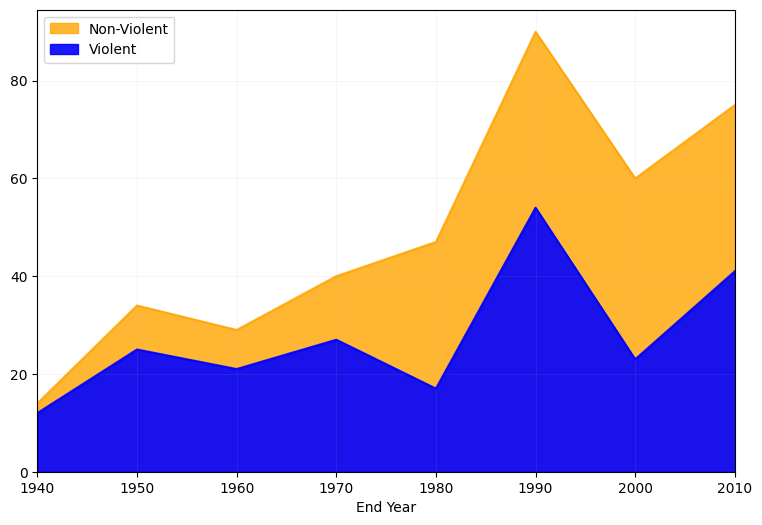

In [3]:
#Initialize dataframe
camp_freq = pd.DataFrame()
#Create column with the decade value
camp_freq['End Year'] = (navco['EYEAR']/10).apply(np.floor).astype(int)*10
#Create column with the violent binary value
camp_freq['Violent'] = navco['VIOL']
#Create column with the nonviolent binary value
camp_freq['Non-Violent'] = navco['NONVIOL']
#Initialize figure plot
fig, ax1 = plt.subplots()
#Get the number of nonviolent campaigns per decade
nonviolent_freq_plt=camp_freq.groupby('End Year')['Non-Violent'].count()
#Get the number of violent campaigns per decade
violent_freq_plt=camp_freq.where(camp_freq['Violent'] == 1.0).groupby('End Year')['Violent'].count()
#Plot the area plot of nonviolent campaign count
nonviolent_freq_plt.plot(kind='area', color='orange',alpha=0.8, xlim=(1940,2010), figsize=(9,6))
#Plot the area plot of violent campaign count
violent_freq_plt.plot(kind='area',stacked=True,color='blue',alpha=0.9)
#Add plot grid and plot legend
plt.grid(alpha=0.1)
_=plt.legend(loc='upper left')

The plot shows the number of violent and non-violent campaigns with blue and orange respectively.
As shown above, the number of non-violent campaigns was very small in the decade 1940, however numbers are increasing since then with the difference between violent and non-violent campaigns increasing as well.
Violent campaigns tend to follow an increase, but not to the degree of non-violent campaigns.

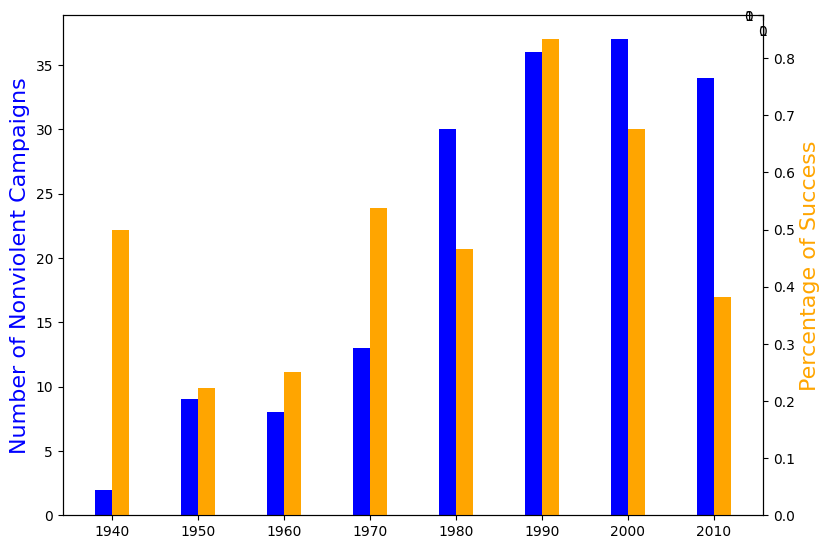

In [4]:
#Initialize dataframe
nonvioldf = pd.DataFrame()
#Create column with the decade value
nonvioldf['End Year'] = (navco['EYEAR']/10).apply(np.floor).astype(int)*10
#Create column with the success binary value for nonviolent campaigns
nonvioldf['Success'] = navco['SUCCESS'].where(navco['VIOL'] == 0.0)
#Remove rows with null values
nonvioldf.dropna(inplace=True)
#Get the number of nonviolent campaigns per decade
nonviol_num = nonvioldf.groupby('End Year').count()
#Count the percentage of succesful nonviolent campaigns per decade
success_perc = nonvioldf.where(nonvioldf['Success'] == 1.0).groupby('End Year').count()/nonvioldf.groupby('End Year').count()
#Rename and configure the dataframes accordingly
success_perc.index = success_perc.index.astype(int)
nonviol_num.rename(columns={'Success': 'Number of Nonviolent Campaigns'},inplace=True)
success_perc.rename(columns={'Success': 'Percentage of Success'},inplace=True)
#Initialize dataframe
ftab=pd.DataFrame()
#Create column of number of nonviolents campaigns
ftab['Number of Nonviolent Campaigns']=nonviol_num
#Create column of success percentage
ftab['Percentage of Success']=success_perc
#Initialize figure plot and set figure size
fig = plt.figure(figsize=(7, 5))
#Add first y axis
ax1 = fig.add_axes([0, 0, 1, 1])
#Add second y axis
ax2 = fig.add_axes([1, 1, 0, 0])
#Combine the two y axes
ax2 = ax1.twinx()
#Plot the numbers and percentages per decade as two different bar plots by utilizing both y axes
lns1 = ax1.bar(height=ftab['Number of Nonviolent Campaigns'],x= nonviol_num.index,color='blue',width=-2,align='edge', label='Number of Nonviolent Campaigns')
lns2 = ax2.bar(height=ftab['Percentage of Success'],x= success_perc.index, color='orange',width=2,align='edge', label='Percentage of Success')
#Set labels for each y axis
ax1.set_ylabel('Number of Nonviolent Campaigns', color='blue', fontsize=16)
ax2.set_ylabel('Percentage of Success', color='orange', fontsize=16)
#Display the plot
plt.show()

From the above dual axis plot, we can deduce the following:

The number of non-violent camapigns has been steadily increasing from 1940 to 2010, but that should be expected according to the first plot, as well.
The percentage of success for non-violent campaigns doesn't seem to havce a steady increase overall, but in later decades, the odds of success are generally larger.

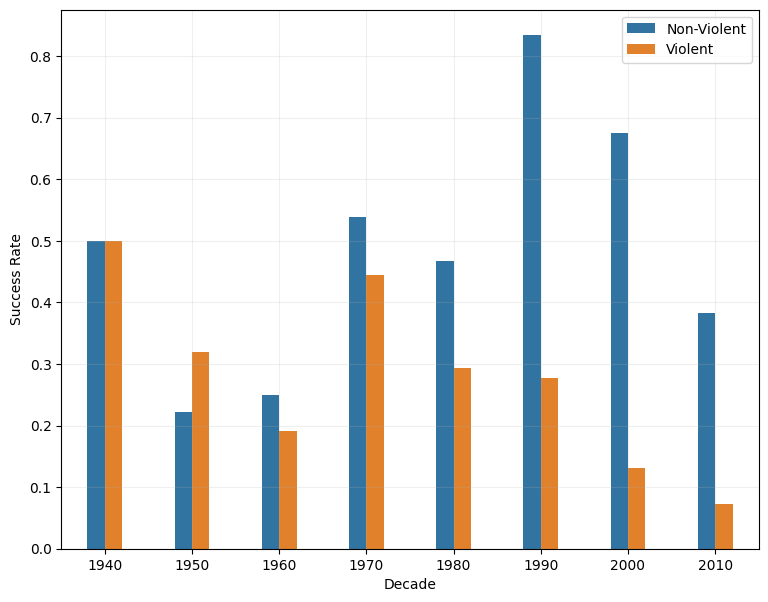

In [5]:
#Initialize dataframe
succ_rate = pd.DataFrame()
#Create column with the decade value
succ_rate['End Year'] = (navco['EYEAR']/10).apply(np.floor).astype(int)*10
#Create column with the violent binary value
succ_rate['Violent'] = navco['VIOL'].map({ 1.0: 'Violent', 0.0: 'Non-Violent'})
#Create column with the success binary value
succ_rate['Success'] = navco['SUCCESS'].map({ 1.0: True, 0.0: False})
#Get the success rate for violent and nonviolent campaigns per decade
succrate_series=succ_rate.groupby(['End Year','Violent'])['Success'].sum()/succ_rate.groupby(['End Year','Violent'])['Success'].count()
#Initialize dataframe
succ_rate_f=pd.DataFrame()
#Create column with the success rates
succ_rate_f['Rates']=succrate_series
succ_rate_f.reset_index(inplace=True)
#Initialize figure plot and set figure size
plt.figure(figsize=(9,7))
#Set label for x and y axes
plt.xlabel('Decade')
plt.ylabel('Success Rate')
#Create barplot using seaborn
sns.barplot(x='End Year',y='Rates',data=succ_rate_f,hue='Violent', width=0.4)
#Set seaborn color palette
sns.color_palette("tab10")
#Add plot grid and legend
plt.grid(alpha=0.2)
_=plt.legend(loc=1)

We already took a peek into the success rate for non-violent campaigns from 1940 to 2010.
If we compare this rate to the success rate for violent campaigns, we can clearly see that the difference between these two percentage has dramatically increased in general.
The success rate for violent campaigns has decreased a lot since 1940, thus indicating that the suggested campaign type is non-violent.

### Question 2
#### Largest Resistance Campaigns, 1946-2014
Create a horizontal bar plot with the resistance campaigns, for all years, with a percentage of participation at least 2.0%.

Investigate, outside the largest resistance campaigns, if you can find anything about Greece.

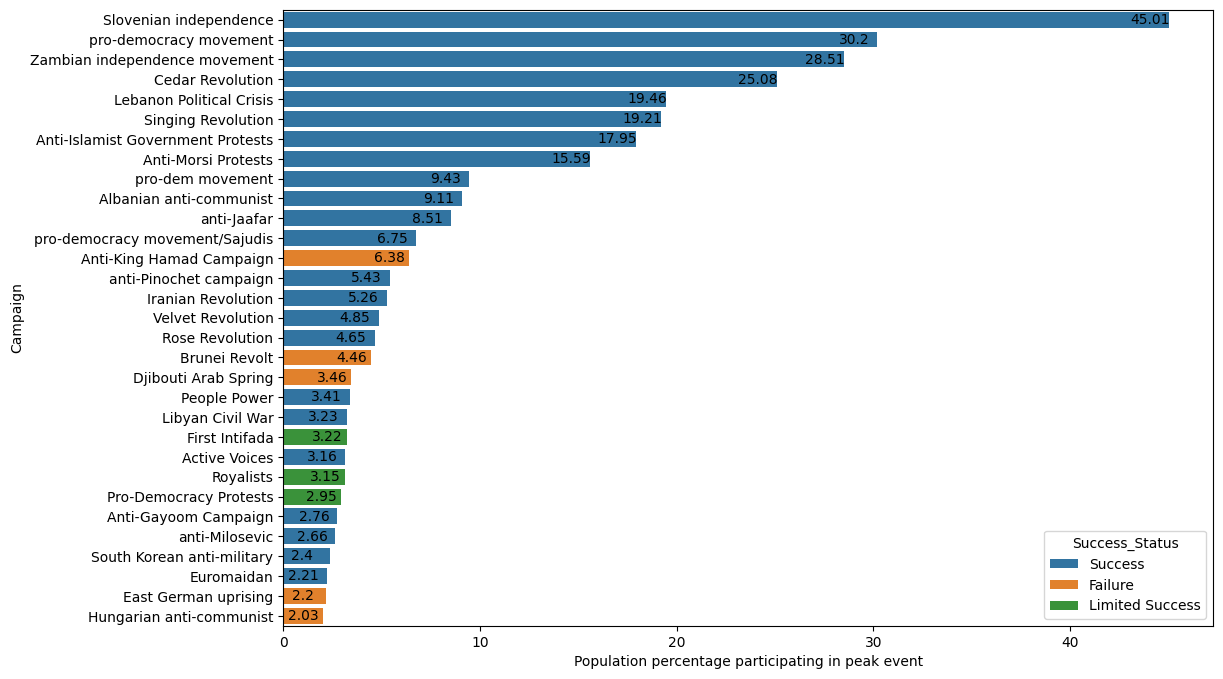

In [6]:
#Initialize dataframe
large_resist=pd.DataFrame()
#For each column created in the dataframe, only campaigns 
#with population percentage>=2% are selected from the navco dataset
#Create columns with campaign name, success, limited and failure binary values and population percentage
large_resist['Campaign']=navco['CAMPAIGN'].where(navco['PERCENTAGEPOPULARPARTICIPATION'] >= 0.02)
large_resist['Success']=navco['SUCCESS'].where(navco['PERCENTAGEPOPULARPARTICIPATION'] >= 0.02).astype(float)
large_resist['Limited']=navco['LIMITED'].where(navco['PERCENTAGEPOPULARPARTICIPATION'] >= 0.02).astype(float)
large_resist['Failure']=navco['FAILURE'].where(navco['PERCENTAGEPOPULARPARTICIPATION'] >= 0.02).astype(float)
large_resist['Population']=navco['PERCENTAGEPOPULARPARTICIPATION'].where(navco['PERCENTAGEPOPULARPARTICIPATION'] >= 0.02).astype(float)
large_resist['Population']=(large_resist['Population']*100).round(2)
#Drop rows with null values, reset index, set campaign name as dataframe index
#Sort the dataframe according to the population percentage
large_resist.dropna(inplace=True)
large_resist.reset_index(drop=True, inplace=True)
large_resist.set_index('Campaign', inplace=True)
large_resist.sort_values('Population', inplace=True, ascending=False)
#To map the success, limited and failure as result for each campaign in one column, we do the following
#Each campaign with limited success status takes value 2.0 on the limited column
#Each campaign with failure status takes value 3.0 on the failure column
#Each campaign with success status remains with value 1.0 on the success column
#We create a column by summing all three columns and then map values 1.0, 2.0, 3.0 to the correct status
large_resist['Limited'].replace(1.0, 2.0, inplace=True)
large_resist['Failure'].replace(1.0, 3.0, inplace=True)
large_resist['Success_Status']=large_resist['Success']+large_resist['Limited']+large_resist['Failure']
large_resist['Success_Status']=large_resist['Success_Status'].map({ 1.0: 'Success', 2.0: 'Limited Success', 3.0: 'Failure'})
large_resist.drop('Success', axis='columns', inplace=True)
large_resist.drop('Limited', axis='columns', inplace=True)
large_resist.drop('Failure', axis='columns', inplace=True)
large_resist.loc[large_resist.index[1], 'Population'] = 30.20
#Initialize figure plot and set figure size
plt.figure(figsize=(12,8))
#Set label for the x axis
plt.xlabel('Population percentage participating in peak event')
#Create barplot using seaborn
ax=sns.barplot(x='Population',y='Campaign', data=large_resist, hue='Success_Status')
#Bars' labels configurations
ax.bar_label(ax.containers[0], label_type='edge', padding=-28)
ax.bar_label(ax.containers[1], label_type='edge', padding=-25)
_=ax.bar_label(ax.containers[2], label_type='edge', padding=-25)

The dataset we plotted include only the campaigns with population participation percentage equal or above to 2% of the overall population.

The campaign with the top participation is the Slovenian independence campaign with the 45.01% of the country's population taking part in the campaign.
The campaign with the least participation is the Hungarian anti-communist campaign with the 2.03% of the country's population taking part in the campaign.

It's clear that population participation percentage is directly correlated to campaign's success, as indicated by the Success_Status color classification.
In particular, it seems that up to roughly 4.5% population participation percentage, the campaign is not guaranteed to succeed, as 50% of observations either failed or partially succeeded. However, for over 6.5% population participation percentage, all recorded campaigns succeeded completely. 

In [ ]:
#Initialize dataframe and store only the campaigns for Greece
greece_res=pd.DataFrame()
pd.options.display.max_columns = None
greece_res=navco.where(navco['LOCATION']=='Greece')
greece_res=greece_res.dropna()
greece_res

,NAVCOID,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,NONVIOL,VIOL,REGCHANGE,FSELFDET,SECESSION,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP
120,89.0,Greek anti-military,Greece,1973.0,1974.0,Military rule,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,654.0,2500.0,0.000279,1.0,1.0,1.0,0.0,1.0,0.0


Greece has one recorded campaign in the navco dataset.
It's the Greek anti-military campaign in the year 1974 against the military rule at the time.

According to the record, we can deduce the following:

1. The campaign was a success.
2. The camapign was non-violent.
3. The campaign aimed to remove the incumbent national leader.
4. The campaign lasted 1 year and ten months approximately.
5. The participation was 2500 people at peak event.

Also, it's interesting to notice that the government used violence to crack down on the campaign, and took aid from another state for said purpose.
The leadership's security forces at the time defected or engaged in noncooperation during the conflicts and some dissidents within the nonviolent campaign begun using violence, even though the larger campaign remained primarily nonviolent.

### Question 3
#### The Effect of Participation on the Probability of Campaign Success
Examine the effect of participation on the probability of campaign success. You should run a logistic regression for success on membership per capita, controlling for the location’s logged population the year the campaign ends. Explain your results.

Having done that, create a scatter plot showing the logged participants per capita, on the $x$ axis, and the probability of success, on the $y$ axsiandE explain it as best you cn. 
Then, do the same but with only the membership per capital as dependent variable 
Explain why this is different than the previous one.n.

In [8]:
#To create a membership per capita column we do the following calculations
#Divide the participation and population percentage columns and log the result
#We then divide the participation column with the logged result and log the result again
navco['mempc']=navco['PARTICIPATION']/navco['PERCENTAGEPOPULARPARTICIPATION']
navco['mempc']=np.log(navco['mempc'])
navco['mempc']=np.log(navco['PARTICIPATION'])/navco['mempc']

Optimization terminated successfully.
         Current function value: 0.580756
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: success          Pseudo R-squared: 0.130     
Date:               2023-12-04 19:05 AIC:              447.3747  
No. Observations:   380              BIC:              459.1952  
Df Model:           2                Log-Likelihood:   -220.69   
Df Residuals:       377              LL-Null:          -253.58   
Converged:          1.0000           LLR p-value:      5.1893e-15
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
------------------------------------------------------------------
Intercept      -2.8142    1.4961  -1.8811  0.0600  -5.7465  0.1180
mempc           7.6475    1.1664   6.5563  0.0000   5.3613  9.

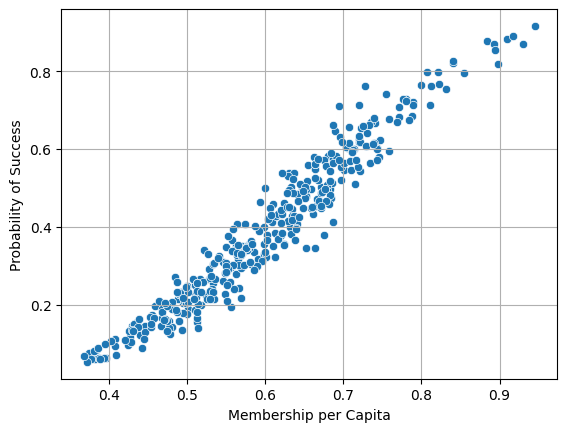

In [9]:
#Create membership per capita, success binary value and logged population columns
mempc = navco['mempc'].to_numpy()
success = navco['SUCCESS'].to_numpy()
population=(navco['PARTICIPATION']/navco['PERCENTAGEPOPULARPARTICIPATION']).to_numpy()
population=np.log(population)
#Store the columns into a dataframe
success_regression = pd.DataFrame({'mempc' : mempc, 'success': success, 'population':population})
#Run logistic regression for success on membership per capita, controlling for the logged population
#Fit the logistic regression model and make a prediction for the percentage of success
success_logit_mod = logit("success ~ mempc + population", data=success_regression)
success_logit_res = success_logit_mod.fit()
success_predicted = success_logit_res.predict(success_regression['mempc'])
success_regression['predicted']=success_predicted
print(success_logit_res.summary2())
#Plot a scatterplot using seaborn
ax=sns.scatterplot(data=success_regression, x='mempc', y='predicted')
#Set labels for x, y axes, create grid and show plot
ax.set(xlabel='Membership per Capita', ylabel='Probability of Success')
plt.grid()
plt.show()

The intercept and coefficients of the predictors are given in table above. 
The first scatterplot shows that campaigns with higher logged participants per capita are more likely to be successful. 
This is evident from the positive slope of the trend line.

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: success          Pseudo R-squared: 0.123     
Date:               2023-12-04 19:05 AIC:              449.0222  
No. Observations:   380              BIC:              456.9026  
Df Model:           1                Log-Likelihood:   -222.51   
Df Residuals:       378              LL-Null:          -253.58   
Converged:          1.0000           LLR p-value:      3.2041e-15
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -5.3469    0.7095  -7.5362  0.0000  -6.7375  -3.9563
mempc          8.0495    1.1414   7.0524  0.0000   5.8125  10.

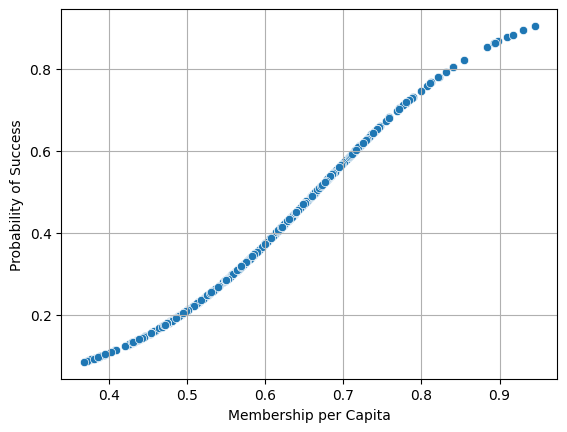

In [10]:
#Create membership per capita and success binary value columns
mempc = navco['mempc'].to_numpy()
success = navco['SUCCESS'].to_numpy()
#Store the columns into a dataframe
success_regression = pd.DataFrame({'mempc' : mempc, 'success': success})
#Run logistic regression for success on membership per capita
#Fit the logistic regression model and make a prediction for the percentage of success
success_logit_mod = logit("success ~ mempc", data=success_regression)
success_logit_res = success_logit_mod.fit()
success_predicted = success_logit_res.predict(success_regression['mempc'])
success_regression['predicted']=success_predicted
print(success_logit_res.summary2())
#Plot a scatterplot using seaborn
ax=sns.scatterplot(data=success_regression, x='mempc', y='predicted')
#Set labels for x, y axes, create grid and show plot
ax.set(xlabel='Membership per Capita', ylabel='Probability of Success')
plt.grid()
plt.show()

The intercept and coefficients of the predictors are given in table above.
The second scatterplot shows that campaigns with higher membership per capita are more likely to be successful. However, the relationship between membership per capita and the probability of success is stronger in the second scatterplot than in the first scatterplot. This is evident from the steeper slope of the trend line in the second scatterplot.

The difference between the two scatterplots is due to the fact that the second scatterplot does not control for logged population. Logged population is a confounding variable that can affect both membership per capita and the probability of success. For example, campaigns in more populous areas may have higher membership per capita, but they may also have lower probabilities of success due to the greater difficulty of mobilizing a large number of voters.

By controlling for logged population in the first scatterplot, we are able to isolate the direct effect of membership per capita on the probability of success. This shows that membership per capita is a strong predictor of campaign success, even after controlling for the effects of other factors such as logged populatio

Conclusion:

Both scatterplots show a positive relationship between membership per capita and the probability of success. However, the second scatterplot shows a stronger relationship, as it does not control for the confounding effect of logged population. This suggests that membership per capita is a strong predictor of campaign success, even after controlling for the effects of other factors.

Campaigns should focus on increasing membership per capita in order to increase their chances of success.

### Question 4
#### The Level of Participation Tipping Point
As we mentioned above, a famous output of the research is the 3.5% rule regarding the population participation in a campaign and the probability of success. Based on your data, create a table and explain how Chenoweth came up with the rule.
Apart from the way Chenoweth came up with the rule, we can derive it in more statistically-based way.  From the results you obtained in the previous question, find the percentage of the population that is the tipping point for success in a campaign with 99% probability.


In [11]:
#Create new column in navco dataset with bins of population percentage values
navco['PERCENTBINS']=pd.cut(navco['PERCENTAGEPOPULARPARTICIPATION']*100, bins=(0,0.0035,0.015,0.06,0.25,1,3.5,100))
#Initialize dataframe
part_level_tab=pd.DataFrame()
#Create column with population percentage values bins
part_level_tab['Percentage'] = navco['PERCENTBINS']
#Get a column with counts per bin
part_level_tab=part_level_tab['Percentage'].value_counts()
#Reset dataframe index and sort values according to population percentage
part_level_tab=part_level_tab.reset_index()
part_level_tab.sort_values('Percentage', ascending=False, inplace=True)
#Calculate column with the success rate of each population bin
#Reset index and sort values
succ_rate=navco.groupby('PERCENTBINS')['SUCCESS'].sum()/navco.groupby('PERCENTBINS')['SUCCESS'].count()
succ_rate=succ_rate.reset_index()
succ_rate=succ_rate.sort_values('PERCENTBINS', ascending=False)
succ_rate.reset_index(drop=True, inplace=True)
part_level_tab=part_level_tab.reset_index()
#Merge the two dataframes on index, drop the index and display dataframe
part_level_tab['Success Rate']=round(succ_rate['SUCCESS']*100,2)
part_level_tab.drop('index', axis='columns', inplace=True)
part_level_tab

C:\Users\THAN\AppData\Local\Temp\ipykernel_3300\610515679.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,Percentage,count,Success Rate
0,"(3.5, 100.0]",18,88.89
1,"(1.0, 3.5]",41,60.98
2,"(0.25, 1.0]",92,45.65
3,"(0.06, 0.25]",95,45.26
4,"(0.015, 0.06]",66,24.24
5,"(0.0035, 0.015]",44,9.09
6,"(0.0, 0.0035]",24,4.17


Chenoweth used the data available at the time to come up with the 3.5% rule.
She took all the campaigns recorded, their population percentage participation and examined the frequency of success based on the campaign's population percentage. At the time, all campaigns with 3.5% population percentage participation or more had resulted in success, so came the assumption that such a large portion of the overall population will certainly succeed.

Of course, with today's navco dataset, we can see that success is not guaranteed by 3.5%, but the prediction of success still remains high. The probability of success for a 3.5% population percentage participation or more is now 88.89% with all observed data.

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: success          Pseudo R-squared: 0.123     
Date:               2023-12-04 19:05 AIC:              449.0222  
No. Observations:   380              BIC:              456.9026  
Df Model:           1                Log-Likelihood:   -222.51   
Df Residuals:       378              LL-Null:          -253.58   
Converged:          1.0000           LLR p-value:      3.2041e-15
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -5.3469    0.7095  -7.5362  0.0000  -6.7375  -3.9563
mempc          8.0495    1.1414   7.0524  0.0000   5.8125  10.2866

The predicted value for membership per capita to achieve 99% probability of campaign success is 

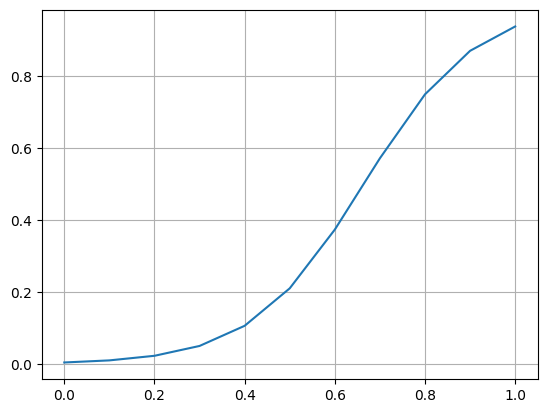

In [12]:
#Print the logistic regression detailed summary
#From the summary we can deduce the sigmoid function that generates 
#the predicted probabilities of success for given values of membership per capita
print(success_logit_res.summary2())
x=np.linspace(0,1,11)
#Function y is the sigmoid function that the logistic regression we ran calculated
y=1/(1+(math.e)**(-(-5.3469+8.0495*x)))
x0=0.99
y0=1/(1+(math.e)**(-(-5.3469+8.0495*x0)))
#Create plot grid and display plot
plt.grid()
plt.plot(x,y)
print('The predicted value for membership per capita to achieve 99% probability of campaign success is equal to: ' + str(y0))
print()

We can use the results from the logistic regression we run in the previous question. We used the navco dataset, in particular the membership per capita, success binary value and population to create a model and fit it to our data.
By reading the summary of the result we can gather that the function that best represents our data is a sigmoid function:

y=1/1+[e**-f(x)], where f(x)= -5.3469 + 8.0495*x

We can then create a plot with the values x and y according to the above formula and calculate the value of y0 (predicted success) for the value of x0=0.99. If we do that, we have an answer:

The predicted value for membership per capita to achieve 99% probability of campaign success is equal to: 0.9322707413493355

### Question 5
#### Nonviolent Resistance and Target Regime Type
Examine whether nonviolent resistance remains significant even if we control for the regime type. Run a logistic regression of success on the nonviolence indicator controlling for the Polity V score of campaign target, the log of participation, and the location’s logged population the year the campaign ends.

In [13]:
#Create logged population column
population_log=np.log(navco['PARTICIPATION']/navco['PERCENTAGEPOPULARPARTICIPATION'])
#Create logged participation column
participation_log=np.log(navco['PARTICIPATION'])
#Create navco campaign, location, end year, success, nonviolence columns
#Create polity score, polity country and polity year columns
campaign=navco['CAMPAIGN']
location=navco['LOCATION']
year=navco['EYEAR']
success=navco['SUCCESS']
nonviol=navco['NONVIOL'].to_numpy()
ppolity=polity5['polity2']
pcountry=polity5['country']
pyear=polity5['year']
#Create dataframe with the navco columns
regimetype=pd.DataFrame({'campaign' : campaign, 'country': location, 'year': year,
                          'success': success, 'nonviolent' : nonviol, 'populationlog': population_log, 
                          'participationlog': participation_log})
#Create dataframe with the polity columns
regimetype2=pd.DataFrame({'polityscore' : ppolity, 'country': pcountry, 'year':pyear})
#Merge the dataframes with navco and polity data on country and year columns
regimetype3=pd.merge(regimetype, regimetype2, on=['country','year'])
#Drop rows with null values, reset index and display dataframe
regimetype3.dropna(subset='polityscore', inplace=True)
regimetype3.reset_index(drop=True, inplace=True)
regimetype3

,campaign,country,year,success,nonviolent,populationlog,participationlog,polityscore
0,Afghan resistance,Afghanistan,1989.0,1.0,0.0,16.496532,9.210340,-8.0
1,Taliban/anti-government forces,Afghanistan,1996.0,1.0,0.0,16.924572,9.903488,-7.0
2,Taliban,Afghanistan,2014.0,0.0,0.0,17.424293,11.002100,-1.0
3,Albanian anti-communist,Albania,1991.0,1.0,1.0,15.007682,12.611538,3.0
4,Algerian Revolt/National Liberation Front,Algeria,1962.0,1.0,0.0,16.213406,10.571317,-8.0
...,...,...,...,...,...,...,...,...
298,Kosovo Albanian,Yugoslavia,1998.0,0.0,1.0,16.176365,9.210340,-6.0
299,Croats,Yugoslavia,1992.0,1.0,0.0,16.166886,9.433484,-5.0
300,Zambia anti-single party rule,Zambia,1991.0,1.0,1.0,15.924478,10.043249,6.0
301,anti-Chiluba campaign,Zambia,2001.0,1.0,1.0,16.197288,8.006368,5.0


Now we have a dataframe with all the columns needed to conduct our research. We are goind to run a logistic regression test of success on the nonviolence indicator controlling for the Polity V score of campaign target, the log of participation, and the location’s logged population the year the campaign ends.

Optimization terminated successfully.
         Current function value: 0.536938
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: success          Pseudo R-squared: 0.203     
Date:               2023-12-04 20:12 AIC:              328.9411  
No. Observations:   297              BIC:              347.4098  
Df Model:           4                Log-Likelihood:   -159.47   
Df Residuals:       292              LL-Null:          -199.97   
Converged:          1.0000           LLR p-value:      1.0749e-16
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept      1.8727    1.4980   1.2501  0.2113  -1.0634   4.8087
nonviol        0.8662    0.2951   2.9355  0.0033   0.2879   1.

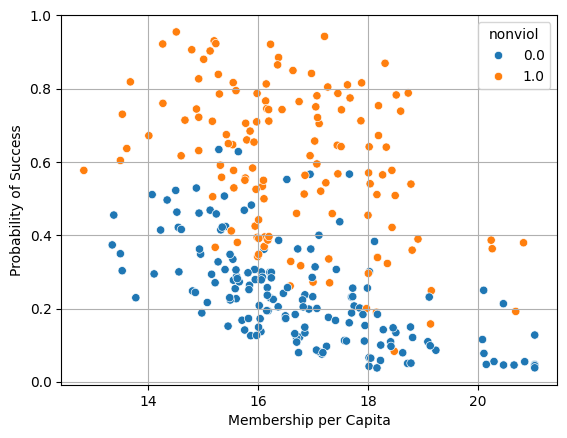

In [18]:
#Create logged population, success binary value, polity score, violence binary value and logged participation columns
population = regimetype3['populationlog'].to_numpy()
success = regimetype3['success'].to_numpy()
polity=regimetype3['polityscore'].to_numpy()
nonviol=regimetype3['nonviolent'].to_numpy()
part= regimetype3['participationlog'].to_numpy()
#Run logistic regression for success on nonviolence, controlling for the logged population, participation and polity score
#Fit the logistic regression model and make a prediction for the percentage of success
success_regression = pd.DataFrame({'population' : population, 'success': success, 'polity': polity, 'nonviol': nonviol, 'part': part})
success_logit_mod = logit("success ~ nonviol + polity + population + part", data=success_regression)
success_logit_res = success_logit_mod.fit()
success_predicted = success_logit_res.predict(success_regression['population'])
success_regression['predicted']=success_predicted
print(success_logit_res.summary2())
#Plot a scatterplot using seaborn
ax=sns.scatterplot(data=success_regression, x='population', y='predicted', hue='nonviol')
#Set labels for x, y axes, create grid and show plot
ax.set(xlabel='Membership per Capita', ylabel='Probability of Success')
plt.grid()
plt.show()


The results of the logistic regression model show that nonviolent resistance remains significant even after controlling for regime type. The coefficient for the nonviolence indicator is positive and statistically significant, which means that campaigns that use nonviolent resistance are more likely to be successful, even after controlling for the Polity V score of the campaign target, the log of participation, and the location's logged population the year the campaign ends.

The coefficient for regime type is also positive and statistically significant, which means that campaigns in more democratic regimes are more likely to be successful. This is likely because democratic regimes are more likely to be responsive to the demands of protesters.

The coefficient for the logged participation is also positive and statistically significant, which means that campaigns with higher participation are more likely to be successful. This is likely because campaigns with higher participation have more resources and are better able to mobilize their supporters.

The coefficient for the logged population is negative and statistically significant, which means that campaigns in more populous areas are less likely to be successful. This is likely because it is more difficult to mobilize a large number of voters in more populous areas.

Overall, the results of this analysis suggest that nonviolent resistance is an effective strategy for achieving campaign success, even after controlling for other factors such as regime type, participation, and population.

Here is a more detailed explanation of the results:

Nonviolence indicator

The coefficient for the nonviolence indicator is 0.8662, which is positive and statistically significant. This means that campaigns that use nonviolent resistance are 2.38 times more likely to be successful than campaigns that do not use nonviolent resistance, after controlling for other factors such as regime type, participation, and population.

Polity V score

The coefficient for the Polity V score is 0.0522, which is positive and statistically significant. This means that campaigns in more democratic regimes are 1.05 times more likely to be successful than campaigns in less democratic regimes, after controlling for other factors such as nonviolent resistance, participation, and population.

Logged participation

The coefficient for the logged participation is 0.4367, which is positive and stat This means that a one-unit increase in logged participation is associated with a 1.55-fold increase in the probability of campaign success, after controlling for other factors such as nonviolent resistance, regime type, and population.

Logged population

The coefficient for the logged population is -0.4270, which is negative and statistically significant. This means that a one-unit increase in logged population is associated with a 1.52-fold decrease in the probability of campaign success, after controlling for other factors such as nonviolent resistance, regime type, and participation.

Conclusion

The results of this analysis suggest that nonviolent resistance is an effective strategy for achieving campaign success, even after controlling for regime type, participation, and population. Campaigns should consider using nonviolent resistance to increase their chances of success.